# Euro Millions

By ***Rok Medves***

Remarks on dataset can be found in ./datasets/README.md


## Loading the dataset

In [7]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load in the data -- could be automated to just pull the data from the webpage
euromillions_draws   = pd.read_csv('./datasets/euro-millions-draws.csv',   index_col=0)
euromillions_winners = pd.read_csv('./datasets/euro-millions-winners.csv', index_col=0)
euromillions_sales   = pd.read_csv('./datasets/euro-millions-sales.csv', usecols=[4,])

euromillions_sales = euromillions_sales.set_index(euromillions_winners.index)

# clean column names
for dataset in (euromillions_draws, euromillions_winners, euromillions_sales):
    dataset.columns = [ col.strip() for col in dataset.columns]

# only temporary:
# 
# On sep 2016 the number of winning numbers changed for the last time (see ./datasets/README.md)
# This flag selects only data after that date
select_only_pre_sep_2016_data = True

# name of the target variable; for use later
target = ['Good no.']


# Dataset Cleaning and Processing

In [ ]:
# ---------------------------- handing NaN values in sales dataset -----------------------------------------

# there is a N/A in the sales dataset 
# find it and set the sales value to the expected total.
# This needs to be done manually because of spaces 
# invalidating the pd.isnull() & pd.isna() functions
#
# the expected number of sales should roughly be 13 * the
# total number of winners
na_loc = euromillions_sales.Sales.str.strip() == 'N/A'
na_ind = euromillions_sales[na_loc].index[0]

# Replace the `N/A` with a values reflecting the sales/winners mean. 
# it's quick and dirty, but it gets the ratio right
euromillions_sales.loc[na_ind] = euromillions_sales.Sales.drop(index = na_ind).astype(float).mean()/euromillions_winners.Total.mean() * euromillions_winners.Total.loc[na_ind]
euromillions_sales = euromillions_sales.astype(float)

# ---------------------------- Filling in missing values for number of winners -----------------------------------------
# When the category with 2 matching numbers is introduced, the dataset gains a column. 
# The following code amends the missing values by setting the number of winners in the group `2` to 0
# Admittedly, this could be done better!
# TODO: Find a better way of filling in missing values without messing up the predictive power of the model

#Splitting the dataset into a NaN region and a non-Nan region
winners_nan, winners_nonan = euromillions_winners[pd.isna(euromillions_winners.Total) == True], euromillions_winners[pd.isna(euromillions_winners.Total) == False],

# Reindexing things
winners_nan.loc[:, '2'], winners_nan.loc[:, 'Total'] = winners_nan.loc[:, 'Total'].copy(), winners_nan.loc[:, '2'].copy()

# Replacing all NaN with 0
winners_nan = winners_nan.fillna(0)

# Combining everything
euromillions_winners = pd.concat([winners_nonan, winners_nan])

# Now we can actually combine the whole dataset 
euromillions = pd.concat([euromillions_draws, euromillions_winners, euromillions_sales], axis = 1)

# ---------------------------- Validate the cleaning procedure -----------------------------------------

# Validate the clean
summed_winnings = euromillions.loc[:, '5+2':'2'].apply(np.sum, axis = 'columns')
total_validation = pd.concat([summed_winnings, euromillions.Total], axis = 1).rename(columns={0: 'true', 'Total' : 'dataset'})

def validate_cleaning(df : pd.DataFrame):
    """
    Validates the cleaning procedure by
    checking whether the total number of
    winners is consistent accross the dataset

    Parameters
    ----------
    df : pandas.Dataframe
        The dataframe to validate the cleaning of

    Returns
    -------
    bool
        Whether the dataset is lean or not
    """

    clean = True

    df_notnan = df[pd.notna(df.dataset)]
    df_diff    = df_notnan.apply(lambda df: df.dataset - df.true, axis = 'columns')
    if df_diff.sum() != 0.0:
        print("The original total columns were wrong!")
        print(df_notnan[df_diff != 0])

        clean = False

    return clean

if validate_cleaning(total_validation): print("Dataset cleaned accordingly")

# trim extra values; flag sself.dataet at the top, when loading the data
def trim_by_date(df, do_select = False) -> pd.DataFrame:
    """ 
    Trims the dataset df with respect to the date.
    Note that this date is hard-coded to match when the 
    euromillions changed the range of their lucky numbers from 11 to 12

    Parameters
    ----------
    df : pandas.Dataframe
        The dataframe we trim
    do_select : bool
        whether or not to do the selection
    
    Returns
    -------
    pandas.Dataframe
        The trimmed array

    """
    min_index = 0
    if do_select:
        date_mask = (euromillions.DD == 27) & (euromillions.MMM == 'Sep') & (euromillions.YYYY == 2016)
        min_index = euromillions[date_mask].index[0]
    
    print("additionally removing {0} entries from dataset".format(min_index))
    return df.loc[df.index >= min_index]

euromillions = trim_by_date(euromillions, select_only_pre_sep_2016_data)




In [9]:
# Save the dataset so that it can be loaded into a quickstart setting
dataset_filename = 'saved-models/saved-dataset.sav'
pickle.dump(euromillions, open(dataset_filename, 'wb'))

## Feature Engineering

I speculate that people like to bet on numbers that are either
- dates (birthdays, anniversaries, etc.)
- 'lucky' numbers, such as 3, 7, 13. These can literally be found on the internet 
- small, as a compounding effect from the above reasons

To leverage this, new features are engineered below 

In [10]:
from src.dataEng import FeatureEngineering

eng = FeatureEngineering(euromillions)
eng.engineer_features()

euromillions


,N1,N2,N3,N4,N5,L1,L2,Jackpot,5+2,5+1,...,has lucky lucky,7 pattern,N sum,L sum,N sum big,L sum big,N sum bin,L sum bin,NL sum,NL sum bin
No.,,,,,,,,,,,,,,,,,,,,,
1611,12,29,33,37,47,5,10,14937900,0,0,...,False,2,158,15,True,True,4,3,173,4
1610,7,23,34,42,48,1,3,90371760,0,1,...,True,1,154,4,True,False,4,0,158,3
1609,21,22,34,41,49,2,7,77415556,0,0,...,True,0,167,9,True,False,4,1,176,4
1608,8,23,27,42,45,1,9,69376023,0,1,...,True,1,145,10,True,False,3,2,155,3
1607,24,26,38,43,46,2,3,55753429,0,1,...,True,0,177,5,True,False,5,0,182,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,5,12,20,24,37,4,11,153361048,0,3,...,False,1,98,15,False,True,2,3,113,1
944,2,12,20,27,30,9,11,140104641,0,2,...,True,1,91,20,False,True,1,5,111,1
943,4,7,14,34,38,4,11,124041722,0,0,...,False,1,97,15,False,True,1,3,112,1


## Defining the target variable

The idea here is the following:
- Let *k* be the class of winnings that we consider i.e. (5+2, 5+1, ..., 2+1, 2)
- Let *f_w,k* be the fraciton of people who have won in a single category *k*. So, *f_w,k = #sales/#(winners in calss k)*
- Let *f_p,k* be the fraction of the prize for a category *k*. These numbers are fixed and are encoded below, and do indeed match with the data
- Let *Pr[k | win]* be the probability that you win the prize for group *k*. NB: *Pr[k] = Pr[k | win] * Pr[win] = Pr[k | win] * 1/13* 

For a given drawn number, one can write the average winnings as
~~~
E[winnings | number] = Jackpot * sum_k Pr[k | win] * Pr[win] * f_p,k * f_w,k
~~~

The only parameter in this equation which depends on the number being drawn is *f_w,k* and this is what we would like to learn!
We define
~~~
Score = S = E[winnings | number] / E[winnings],
~~~
where *E[winnings]* is the aveage of the winnings throughout all the numbers.

This should split numbers into 2 regions: 
1. Numbers with score >1:  These numbers are better than average
2. Numbers with score <=1: These numbers are worse than average

The below table describes the proportions of the prize fund allocated to the particular winning group *(N, L)* [copied from above]
| Winning group (N, L) | 5+2 | 5+1 | 5+0 | 4+2 | 4+1 | 3+2 | 4+0 | 2+2 | 3+1 | 3+0 | 1+2 | 2+1 | 2+0 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| % of prize fund | 50 | 2.61 | 0.61 | 0.19 | 0.35 | 0.37 | 0.26 | 1.30 | 1.45 | 2.70 | 3.27 | 10.30 | 16.59 |

**Implementation** : found in `src/dataEng.py`

In [11]:

# Score the dataset
euromillions = eng.score_dataset(euromillions)

best = euromillions[euromillions["avg win"] == euromillions["avg win"].max()].iloc[0]
worst= euromillions[euromillions["avg win"] == euromillions["avg win"].min()].iloc[0]
print(pd.DataFrame([best, worst], index = ["best", "worst"]))

       N1  N2  N3  N4  N5  L1  L2   Jackpot  5+2  5+1  ...  7 pattern  N sum  \
best    3   6  13  40  42   7  11  26337501    0    1  ...          0    104   
worst  12  29  33  37  47   5  10  14937900    0    0  ...          2    158   

       L sum  N sum big  L sum big  N sum bin  L sum bin  NL sum  NL sum bin  \
best      18      False       True          2          4     122           2   
worst     15       True       True          4          3     173           4   

        avg win  
best   1.765591  
worst  0.170171  

[2 rows x 40 columns]


# Visualising the dataset and exploratory analysis

## Simple probabalistic analysis

Given that we know what the winning probability
*Pr[N, L]*
is, does the data follow that distribution?

*Answer*: yes

**Observation:**

If running with 
~~~
select_only_pre_sep_2016_data = True
~~~
then the winnings do somewhat follow the expected curves. On the other hand, running with
~~~
select_only_pre_sep_2016_data = False
~~~
breaks the pattern.
This validates the observations from `./datasets/README.md`

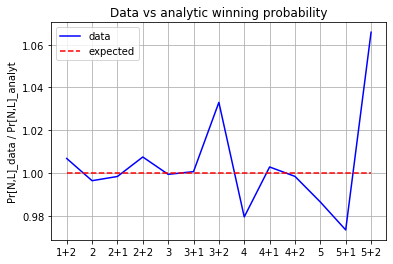

In [12]:
# get info from data
prob_win = 1./13 # The probability to win the lottery; Pr[win]
n = len(euromillions.index)
prob_NL_data = euromillions.mean() * n / euromillions.sum()['Total'] * prob_win # Pr[N, L] = Pr[N, L | win] * Pr[win]

xx = []
yy = []


for N, L in itertools.product(range(1, 6), range(0, 3)):
    nl_tag = str(N)+ ("+"+str(L) if L!=0 else "")
    if nl_tag in prob_NL_data:
        data_analyt_ratio = prob_NL_data.loc[nl_tag] / eng.prob_NL_analyt(N, L)

        xx.append(nl_tag); yy.append(data_analyt_ratio)

plt.figure()
plt.ylabel("Pr[N,L]_data / Pr[N,L]_analyt")
plt.grid()
plt.title("Data vs analytic winning probability")
plt.plot(xx, yy, 'b-', label = 'data')
plt.plot(xx, 1+np.zeros(len(xx)), 'r--', label='expected')
plt.legend()
plt.show()

## The distribution of the average winnings variable


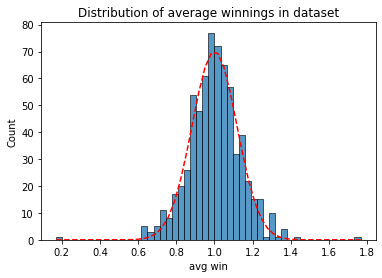

average located at 1.000, with standard deviation: 0.118


In [13]:
from scipy.optimize import curve_fit

n_bin = 50
hist, bins = np.histogram(euromillions["avg win"], bins = n_bin)

bin_cent = np.zeros(len(hist))
for i in range(len(bins)-1):
    bin_cent[i] = (bins[i]+bins[i+1])/2.

bins_cent = (bins[:-1] + bins[1:])/2.

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 1.]

coeff, var_matrix = curve_fit(gauss, bin_cent, hist, p0=p0)

sns.histplot(data=euromillions, x="avg win", kde=False, bins = n_bin)
xx = np.linspace(worst["avg win"], best["avg win"], n_bin)
yy = gauss(xx, coeff[0], coeff[1], coeff[2])
plt.plot(xx, yy, 'r--')
plt.title("Distribution of average winnings in dataset")
plt.show()

print(f"average located at {coeff[1]:.3f}, with standard deviation: {coeff[2]:.3f}")

### Create a binary class for "good" and "bad" numbers

Based on the fact that the scores are distributed as a gaussian, we say that 

In [14]:
def gen_class_from_score(df : pd.DataFrame, s : float, cutoff=0.5) -> pd.DataFrame:
    """
    Based on the standard deviation of the scores in the 
    dataset, assign a 'Good no.' class to each based on how many
    standard deviations one is away from the mean

    Parameters
    ----------
    df: pd.DataFrame
        The DataFrame to be classified 

    s : float
        The standard deviation of the 
        distribution of the 'avg win'
        variable in the dataset df
    
    cutoff: float
        Regulates how many standard 
        deviations away the 'Class' label
        is set: distance = s*cutoff

    Returns
    -------
    pd.DataFrame
        The classified dataframe
    """

    # classify each datapoint into a good or bad data point
    good_bad_class = df.apply(lambda row: 1 if row['avg win'] >= 1+s*cutoff else 0, axis = 1)
    df = pd.concat([df, good_bad_class], axis = 1).rename(columns={0: 'Good no.'})

    return df

cutoff = 0.0
euromillions = gen_class_from_score(df = euromillions, s = coeff[2], cutoff = cutoff)


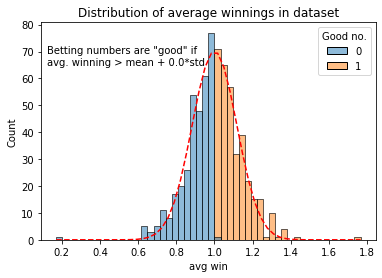

In [15]:
# Let us visualise the new distribution
sns.histplot(data=euromillions, x="avg win", kde=False, bins = n_bin, hue = 'Good no.')
plt.plot(xx, yy, 'r--')
plt.text(x=0.12, y = 65, s = f"Betting numbers are \"good\" if\navg. winning > mean + {cutoff}*std")
plt.title("Distribution of average winnings in dataset")

plt.savefig(fname = "plots/avg-winnings-class.png", format = "png")

plt.show()

## More data exploration given the binary class "good" and "bad" numbers

### Pivot table

In [16]:
for x in euromillions.loc[:, "is date":].drop(["Good no."], axis=1):
    if (euromillions[x].dtype != 'float64') :
        print('Good no. Correlation by:', x)
        print(euromillions[[x, target[0]]].groupby(x, as_index=False).mean())
        print('-'*20, '\n')

Good no. Correlation by: is date
   is date  Good no.
0    False  0.633136
1     True  0.452191
-------------------- 

Good no. Correlation by: is post 2000
   is post 2000  Good no.
0         False  0.499165
1          True  0.486111
-------------------- 

Good no. Correlation by: is this year
   is this year  Good no.
0         False   0.49925
1          True   0.25000
-------------------- 

Good no. Correlation by: lucky numbers
   lucky numbers  Good no.
0              0  0.521127
1              1  0.505660
2              2  0.502488
3              3  0.392157
4              4  0.416667
-------------------- 

Good no. Correlation by: lucky lucky numbers
   lucky lucky numbers  Good no.
0                    0  0.496528
1                    1  0.500000
2                    2  0.492537
-------------------- 

Good no. Correlation by: has lucky
   has lucky  Good no.
0      False  0.521127
1       True  0.491493
-------------------- 

Good no. Correlation by: has lucky lucky
   has luck

Discovery:
- The "is post 2000" feature has basically no preditive power. 
- Whether the sum of numbers is big or small has quite a good effect 

## Some more descriptive plots

- We find that the sum of all the numbers people bet on is very important

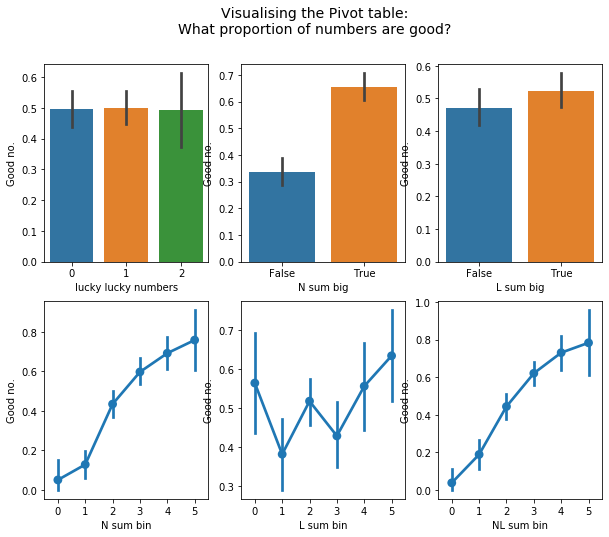

In [17]:
fig, saxis = plt.subplots(2, 3,figsize=(10,8))

fig.suptitle("Visualising the Pivot table:\nWhat proportion of numbers are good?", fontsize = 14)

sns.barplot(x = 'lucky lucky numbers', y = 'Good no.', data=euromillions, ax = saxis[0,0])
sns.barplot(x = 'N sum big',   y = 'Good no.', data=euromillions, ax = saxis[0,1])
sns.barplot(x = 'L sum big',  y = 'Good no.', data=euromillions, ax = saxis[0,2])

sns.pointplot(x = 'N sum bin',  y = 'Good no.',  data=euromillions, ax = saxis[1,0])
sns.pointplot(x = 'L sum bin',   y = 'Good no.',  data=euromillions, ax = saxis[1,1])
sns.pointplot(x = 'NL sum bin', y = 'Good no.', data=euromillions, ax = saxis[1,2])

Text(0.5, 1.0, 'lucky2 numbers vs NL sum')

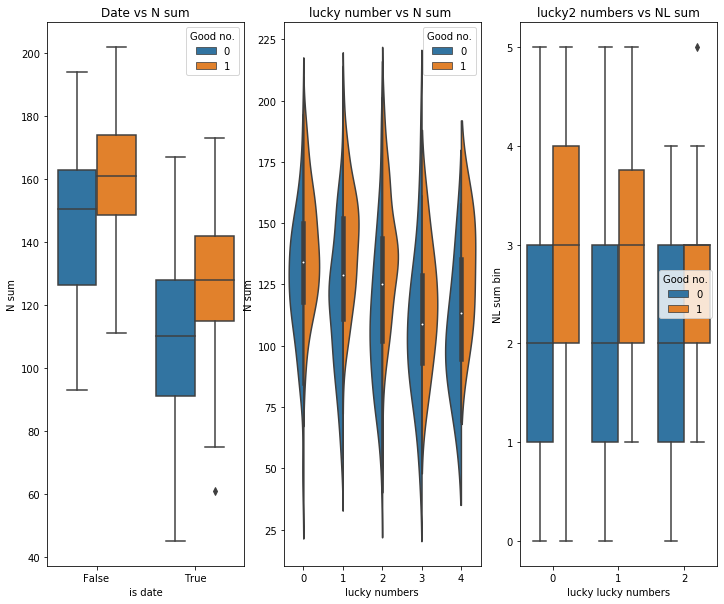

In [18]:
#graph distribution of qualitative data:
# we know that the sum over Ns mattered in whether we have a good number or not;
# now let's compare sum N and a 2nd feature
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(12,10))

sns.boxplot(x = 'is date', y = 'N sum', hue = 'Good no.', data = euromillions, ax = axis1)
axis1.set_title('Date vs N sum')

sns.violinplot(x = 'lucky numbers', y = 'N sum', hue = 'Good no.', data = euromillions, split = True, ax = axis2)
axis2.set_title('lucky number vs N sum ')

sns.boxplot(x = 'lucky lucky numbers', y ='NL sum bin', hue = 'Good no.', data = euromillions, ax = axis3)
axis3.set_title('lucky2 numbers vs NL sum')

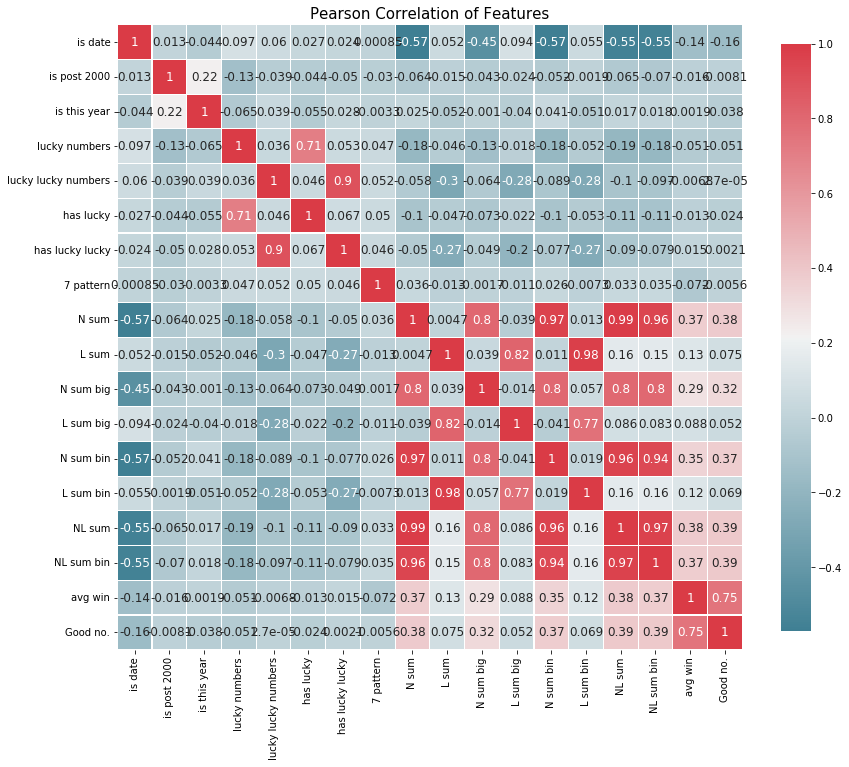

In [19]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(euromillions.loc[:, "is date":])

## Thoughts on exploratory analysis
- At this point, the sum of all the numbers bet on ("N sum") is obviously a good feature. 
- Well-correlated with "N sum" is "is date" and "lucky numbers" (The above plots actually make it seem like betting on high lucky numbers is a good idea, haha!).

Testing this out via a soft of pivot table:

In [20]:
#group by or pivot table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html

# pivot_big = euromillions[euromillions["N sum big"]==1].groupby(['is date','lucky numbers'])['Good no.'].agg({'Good no.':['mean', 'count']})
pivot_big = euromillions[euromillions["N sum big"]==1].groupby(['is date','lucky numbers'])['Good no.'].agg(['mean', 'count'])
print('Quality of BIG betting numbers: \n',pivot_big)

pivot_small = euromillions[euromillions["N sum big"]==0].groupby(['is date','lucky numbers'])['Good no.'].agg(['mean', 'count'])
print('Quality of SMALL betting numbers: \n', pivot_small)

Quality of BIG betting numbers: 
                            mean  count
is date lucky numbers                 
False   0              0.694444     36
        1              0.671642     67
        2              0.756098     41
        3              0.500000      6
        4              1.000000      1
True    0              0.521739     46
        1              0.689189     74
        2              0.649123     57
        3              0.444444      9
        4              0.666667      3
Quality of SMALL betting numbers: 
                            mean  count
is date lucky numbers                 
False   0              0.000000      3
        1              0.166667     12
        2              0.000000      1
        3              0.000000      1
        4              0.000000      1
True    0              0.438596     57
        1              0.321429    112
        2              0.323529    102
        3              0.371429     35
        4              0.285714  

# Model Training

The three most important features in the dataset are
1. *NL sum*: the sum of the numbers people bet. Larger numbers are preferred
2. *is date*: whether or not the numbers are a valid date. Non-dates are preferred
3. *lucky numbers*: Whether or not people have bet on lucky numbers

Now we split the dataset into a train and test set and lock in our selections of variables

In [21]:
from sklearn import ensemble
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import model_selection
from sklearn import svm
from sklearn import tree

target = ['Good no.']

NL_lab = ['N'+ str(i) for i in range(1,6)] + ['L1', 'L2']

x_lab_all = ['is date',        'is this year',
            'lucky numbers',   'lucky lucky numbers',   'has lucky',   'has lucky lucky', 
            # '7 pattern',
            'N sum', 'L sum',  'NL sum', 'N sum big', 'L sum big', 
            'N sum bin', 'L sum bin', 'NL sum bin']
xy_lab_all = x_lab_all + target
x_lab_bin = [
            'is date',         'is this year',
            'lucky numbers',   'lucky lucky numbers',   'has lucky',   'has lucky lucky', 
            # '7 pattern',
            'N sum big', 'L sum big', 'N sum bin', 'L sum bin', 'NL sum bin'
            ]
xy_lab_bin = x_lab_bin + target

x_lab_NL_bin = x_lab_bin + NL_lab

x_lab  = x_lab_bin
xy_lab = x_lab + target

X_train, X_test, y_train, y_test = model_selection.train_test_split(euromillions.drop(target, axis = 1), euromillions[target], test_size=0.20, random_state=11)


## XGBoost + Random Forest + SVM --> voting ensemble

Inspired by the above, lets train an XGBoost and a RF and combine the results.
Do the optimisation with GridSearch X-val

In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from time import perf_counter
from sklearn import model_selection

# Set things up for optimisation

grid_n_estimator = [10, 50, 100, 150, 300, 500]
grid_learn = [.01, .03, .05, .1, .25, 0.4]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_gamma = [.1, .25, .5, .75, 1.0, 'auto']
grid_criterion = ['gini', 'entropy']
grid_seed = [0]

MLA = [
    ('rf', RandomForestClassifier()),
    ('xgboost', GradientBoostingClassifier()),
    ('C-SVM', SVC())
]

grid_param = [
    [{
    #RandomForestClassifier
    'n_estimators': grid_n_estimator,
    'criterion': grid_criterion, 
    'max_depth': grid_max_depth, 
    'oob_score': [True],
    'random_state': grid_seed
    }],

    [{
    #GradientBoostingClassifier
    'learning_rate': grid_learn,
    'n_estimators':  grid_n_estimator,
    'max_depth':     grid_max_depth, 
    'random_state':  grid_seed
    }],

    [{
    # SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
    # 'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [0.5,1,2,3,4,5],
    'gamma': grid_gamma,
    'decision_function_shape': ['ovo', 'ovr'], #default:ovr
    'probability': [True],
    'random_state': grid_seed
    }]
]


cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .25, train_size = .75, random_state = 0 ) 
start_total = perf_counter()

for mla, param in zip(MLA, grid_param):
    print(f"optimising {mla[0]}")

    start = perf_counter()
    best_search = model_selection.GridSearchCV(estimator = mla[1], n_jobs = 6, param_grid=param, cv = cv_split, scoring='roc_auc')
    best_search.fit(X_train[x_lab], np.ravel(y_train))
    run = perf_counter() - start
    
    best_param = best_search.best_params_

    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(mla[1].__class__.__name__, best_param, run))
    mla[1].set_params(**best_param) 

run_total = perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

optimising rf
The best parameter for RandomForestClassifier is {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 300, 'oob_score': True, 'random_state': 0} with a runtime of 44.02 seconds.
optimising xgboost
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 10, 'random_state': 0} with a runtime of 195.97 seconds.
optimising C-SVM
The best parameter for SVC is {'C': 0.5, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'probability': True, 'random_state': 0} with a runtime of 6.00 seconds.
Total optimization time was 4.10 minutes.
----------


## Evaluating Model performance

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

for mla in MLA:
    model_name = mla[0]
    model = mla[1]
    model.fit(X_train[x_lab], np.ravel(y_train))

    prediction = model.predict(X_test[x_lab])
    score = accuracy_score(prediction, y_test)

    print(f"{model_name} accuracy on test dataset: {score:.3f}")


print("uniting the three into a hard/soft-voting classifier")

print('-'*10)
from sklearn import ensemble
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = MLA , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, X_train[x_lab], np.ravel(y_train), cv  = cv_split, return_train_score=True)
grid_hard.fit(X_train[x_lab], np.ravel(y_train))

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))

acc_score = accuracy_score(grid_hard.predict(X_test[x_lab]), y_test)
roc_score = roc_auc_score (grid_hard.predict(X_test[x_lab]), y_test)

print(f"hard-voting accuracy on test dataset: {100*acc_score:.1f}\nhard-voting AUC on test dataset: {100*roc_score:.1f}")

print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = MLA , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, X_train[x_lab], np.ravel(y_train), cv  = cv_split, return_train_score=True)
grid_soft.fit(X_train[x_lab], np.ravel(y_train))

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))

acc_score = accuracy_score(grid_soft.predict(X_test[x_lab]), y_test)
roc_score = roc_auc_score (grid_soft.predict(X_test[x_lab]), y_test)

print(f"soft-voting accuracy on test dataset: {100*acc_score:.1f}\nsoft-voting AUC on test dataset: {100*roc_score:.1f}")

print('-'*10)


rf accuracy on test dataset: 0.652
xgboost accuracy on test dataset: 0.659
C-SVM accuracy on test dataset: 0.652
uniting the three into a hard/soft-voting classifier
----------
Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 68.88
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 65.90
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 7.01
hard-voting accuracy on test dataset: 65.2
hard-voting AUC on test dataset: 65.2
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 68.71
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 65.97
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 6.81
soft-voting accuracy on test dataset: 66.7
soft-voting AUC on test dataset: 66.9
----------


In [24]:
model = grid_soft
filename = 'saved-models/soft-vote-model.sav'
pickle.dump(model, open(filename, 'wb'))

# sample_filename = 'saved-models/sample-input.sav'
# sample_input= X_test[x_lab].sample()
# pickle.dump(sample_input, open(sample_filename, 'wb'))

tags_filename = 'saved-models/model-lables.sav'
pickle.dump(x_lab, open(tags_filename, 'wb'))


